In [1]:
import edhec_risk_kit as eh
import pandas as pd
import numpy as np
%reload_ext autoreload
%autoreload 2

In [ ]:
stock = eh.download_yahoo_stocks('SBER.ME', 'Close')

In [ ]:
r = stock.pct_change()
r = r.dropna()

# Отклонение от нормльного распределения

### Skewness

Показатель смещения распределения.

Относительной оценкой смещения может служить сравнение медианы(median) и среднего (mean) случайной величины. 

Медиана характеризует насколько часто появляется случайное значени, среднее характеризует ожидаемое значение. 

Если значение частоты появления случайной величины, другими словами, медианы ниже чем значение ожидаемой величины - среднего значения, то смещение происходит в левую сторону относительно среднего.


In [ ]:
e = pd.Series([-3, -3, -2, -2, -1, 4, 8])
e = e.to_frame(name='Series')
e = pd.concat([e.mean(), e.median()], axis=1)
e.columns = ['mean', 'median']
e

Чтобы количествено оценить степень смещения используется формула skewness
$$S(R)=\frac{E[(R-E(R))^3]}{\sigma^3_R}$$

In [ ]:
eh.skewness(r)

In [ ]:
import scipy.stats
scipy.stats.skew(r)

Можно проверить корректность вычислений skewness относительно нормльного распределения

In [ ]:
import numpy as np
random_normal_r = np.random.normal(0, .15, size=(263,1))
eh.skewness(random_normal_r)

## Kurtosis

Количественная мера характеризующая толщину "хвоста" в плотности распределения. Kurtosis в нормальном распределении равняется 3.

$$S(R)=\frac{E[(R-E(R))^4]}{\sigma^4_R}$$

Для нормального распределения

In [ ]:
scipy.stats.kurtosis(random_normal_r)

In [ ]:
eh.kurtosis(r)

## Jarque-Bera Test

Статистическая оценка является ли случайная величина нормльным распределением.

$$JB=\frac{n}{6}(S^2+\frac{(K-3)^2}{4})$$

In [ ]:
scipy.stats.jarque_bera(random_normal_r)

In [ ]:
r.aggregate(eh.is_normal)

# Semi-deviation

Semi-deviation это величина отклонения (deviation), которая считается по выборке значений () которые ниже среднего значения или ниже нуля.
$$\mathtt{\sigma_{semi}=\sqrt{\frac{1}{N}\sum{R_t-\overline{R}}}}$$
$\mathtt{N}$ - количество значений, которые ниже среднего значения или нуля.

In [ ]:
eh.semideviation(r) * 100

# VaR - Value at Risk

VaR - максималные велечина убытка за рассматриваемый промежуток времени при заданном уровне вероятности.

Есть несколько вариантов расчета:
- На основе исторических данных
- Параметрический метод на основе кривой Гаусса
- Парамтрический метод основанный не на кривой Гаусса
- Метод Cornish-Fisher

## Метод расчета на основе исторических данных

Для расчета можно воспользоваться функцией из пакета Numpy - percentile. 

Можно, например, расчитать минимальную величину потерь в 5% самых негативных исходах или, другими словами, что в 95% случаях потери будут составлять не более этой величины.

In [ ]:
import numpy as np
import pandas as pd

np.percentile(r, 5)

## Параметрический метод на основе кривой Гаусса

Для нормального распределения величины можно посчитать на основе z-score стандартного отклонения, подробно про z-score на [wiki]
(https://en.wikipedia.org/wiki/Standard_score)

$$VaR_{\alpha}=-(\mu + z_{\alpha}\sigma)$$

**Пример:** Портфель с .5% ежемесяной доходностью и .4% волатильностью, нужно рассчитать 95% VaR для портфеля на основе Гауссианы. 

In [ ]:
import seaborn as sns
import matplotlib as plt
from scipy import stats
import matplotlib.pyplot as plt

mu = .5
sigma = 4
x5 = -6.1

extend = 3

xx = np.arange(mu-extend*sigma, mu+extend*sigma, 0.1)
yy = stats.norm.pdf(xx, loc=mu, scale=sigma)
delta = 0.000000001
xxx = xx[xx<=x5]
yyy = yy[xx<=x5]

plt.fill_between(xxx, yyy, alpha=0.1, color='blue')

sns.lineplot(x=xx, y=yy).set_title('95% monthly Gaussian VaR=6.1 example')
sns.lineplot(x=[mu, mu+delta], y=[0, yy.max()], markers='.')
sns.lineplot(x=[x5, x5+delta], y=[0, stats.norm.pdf(x5, loc=mu, scale=sigma)])

## Метод Cornish-Fisher

Подход которые заключается в оценке VaR учитывая что распределение случайной величины не является нормальным.

$$\tilde{z_{\alpha}}=z_{\alpha}+\frac{1}{6}(z^2_{\alpha}-1)S+\frac{1}{24}(z^3_{\alpha}-3z_{\alpha})(K-3)-\frac{1}{36}(2z^3_{\alpha}-5z_{\alpha})S^2$$

$$VaR_{mod}(1-\alpha)=-(\mu+\tilde{z_{\alpha}}\sigma)$$

* $\tilde{z_{\alpha}}$ - z-score отличного от Гаусса распределения
* $z_{\alpha}$ - z-score распределения Гаусса
* $S$ - scewness
* $(K-3)$ - excess kurtosis

In [ ]:
r.columns = ['SBER']
var_list = [eh.var_historic(r), eh.var_gaussian(r), eh.var_gaussian(r, modified=True)]
comparision = pd.concat(var_list, axis=1)
comparision.columns = ['Historic', 'Gaussian', 'Cornish-Fisher']
comparision.plot.bar(title='SBER Indices: Var')

# CVaR - Conditional VaR

Величина оценивающая величину риска за пределами VaR, рассчитывается по формуле
$$CVaR=-E(R|R\leq-VaR)=\frac{\int\limits_{-\infty}^{VaR}xf_R(x)d(x)}{F_R(-VaR)}$$
где $f_R$ - плотность вероятности, а $F_R$ - функция распределения.

СVaR это среднее значение случайной величины, которая находится за VaR.

**Пример** В последовательности ежемесячной доходности -4%, +5%, +2%, -7%, +1%, +0.5%, -2%, -1%, -2%, +5%, нужно найти 80% CVaR для портфеля.

In [ ]:
seq = [-4, 5, 2, -7, 1, 0.5, -2, -1, -2, 5]
seq = pd.Series(seq)
per_20 = np.percentile(seq, 20, interpolation='nearest')
lower_per_20 = seq[seq<-2]
cvar = lower_per_20.mean()
cvar

In [ ]:
eh.cvar_historic(r)

# Week 2. An Introduction to Portfolio Optimization

Modern portfolio theory was born with the efficient frontier analysis of Markowitz (1952).

Рассмотрим оптимизацию портфеля, который состоит из 2-х активов А и B c показателями:

In [ ]:
description = pd.DataFrame([[4,10],[6,14]], columns=['Return', 'Volatility'])
description = description.rename({0: 'A', 1: 'B'}, axis='index')
description.plot.scatter(x='Volatility', y='Return', c='DarkBlue', xlim=(6, 16), ylim=(2, 8))

Если составить портфель из активов А и B, то доходность совокупная доходность
рассчитывается как среднезвешенное активово в портфеле:

$$R(\omega_A,\omega_B)=\omega_AR_{a}+\omega_BR_b$$

Для расчет дисперсии используется формула:

$$\sigma^2(\omega_A,\omega_B)=\sigma^2_A\omega^2_A+\sigma^2_B\omega^2_B+2\sigma_A\sigma_B\omega_A\omega_B\rho_{A,B}$$

$\rho_{A,B}$ - коэффициент корреляции между 2-я случайными величинами

Два актива считаются идеально скоррелированными при $\rho_{A,B}=1$

In [ ]:
ind = eh.get_ind_returns()
ind.head()

In [ ]:
eh.drawdown(ind['Food'])['Drawdown'].plot.line(figsize=(12,6))

In [ ]:
eh.var_gaussian(ind, modified=True).sort_values().plot.bar(figsize=(12,6))

In [ ]:
eh.sharp_ratio(ind["2000":], 0.03, 12).sort_values().plot.bar(title="Industy Sharp Ratios", figsize=(12,6), color="goldenrod")

In [ ]:
er = eh.annualize_rets(ind["1995":"2005"], 12).sort_values().plot.bar(figsize=(12,6))

In [ ]:
cov = ind["1996":"2005"].cov()
cov.head()

## Markowitz Optimization and the Efficient Frontier

Пограничный анализ является поиск оптимальной комбинации активов в портфеле с разными весами,
при которых уровень риска будет минимальными при заданном уровне доходности.

Общую доходность портфеля состоящего из нескольких активов можно записать при помощи обобщенной формулы:

$$R_P=\sum_{i=1}^{k}\omega_{i}r_i$$

В матричной записи эта формула выглядет как

$$R=\omega^Tr$$

Обобщенная формуа для дисперсии портфеля:

$$\sigma^2_p=\sum_{i=1}^{k}\sum_{j=1}^{k}\omega_i\omega_j\sigma_i\sigma_j\rho_{ij}$$

$$Covariance(i,j)=\sigma_i\sigma_j\rho_{ij}=\sigma_{ij}$$

В матричной форме формула для дисперсии выглядет как

$$\sigma^2_p=\omega^T\Sigma\omega$$

где $\Sigma$ (не путать с суммой $\sum$) матрица размерности $k\times k$ в которой каждый элемент
на позиции $i$ и $j$ есть коэффициент ковариации $\sigma_{ij}$ между активами $i$ и $j$
и равен $\sigma_i\sigma_j\rho_{ij}$. Диагональный элемент матрицы равен дисперсии актива
$\sigma_{ii}=\sigma_i\sigma_i\rho_{ii}=\sigma^2_i$ (одинаковые активный идеально скоррелированы между
собой, поэтому $\rho_{ii}=1$)

Решать задачу оптимизации - нахождения минимумального уровня риска при заданному уровне доходности,
будем при помощи квадратичного программирования (Quadratic Optimization). Другими словами, для уровнения

$$\sigma^2_p=\omega^T\Sigma\omega$$

нужно найти минимум при следующих ограничениях:

$$w\geq0$$ - все веса должны быть больше или равны нулю,
$$w^T1$$=1 - сумма всех весов должна равнять единице,
$$w^TR=r_0$$ - доходность портфеля должна быть заданного уровня

In [ ]:
sample = ind["1996":"2000"]
er = eh.annualize_rets(sample, 12)
cov = sample.cov()
l = ['Food', 'Beer', 'Smoke', 'Coal']
er[l]

In [ ]:
cov.loc[l, l]

In [ ]:
weights = np.repeat(1/4, 4)
weights

In [ ]:
eh.portfolio_return(weights, er[l])

In [ ]:
eh.portfolio_vol(weights, cov.loc[l,l])

### 2 Asset Frontier

In [ ]:
l = ['Games', 'Fin']
n_points = 20
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
weights

In [ ]:
rets = [eh.portfolio_return(w, er[l]) for w in weights]
vols = [eh.portfolio_vol(w, cov.loc[l, l]) for w in weights]
ef = pd.DataFrame({"R": rets, "Vol": vols})
ef.plot.scatter(x="Vol", y="R")

In [ ]:
l = ['Fin', 'Beer']
eh.plot_ef2(30, er[l], cov.loc[l,l])

### N-Asset Efficient Frontier

In [2]:
ind = eh.get_ind_returns()
sample = ind["1996": "2000"]
er = eh.annualize_rets(sample, 12)
cov = sample.cov()

In [3]:
w15 = eh.minimize_vol(0.20, er[l], cov.loc[l, l])
eh.portfolio_vol(w15, cov.loc[l,l])

NameError: name 'l' is not defined

In [ ]:
eh.plot_ef2(25, er[l], cov.loc[l,l])

In [ ]:
w15


In [ ]:
l = ['Smoke', 'Fin', 'Games', 'Coal']
eh.plot_ef(25, er, cov)

## Fund Separation Theorem and The Capital Market Line

Ситуация полностью меняетмя когда на рынке есть активы с нулевым риском и ненулевой доходностью.
Оптимальный портфель, который можно составить из рисковых активов и безрисковых можно изобразить
c помощью наклонной линии, тангенс угла которой равен коэффициенту Sharp Ratio

$$SR_p=\frac{\mu_p-r_f}{\sigma_p}=\frac{\sum_{i=1}^{N}\omega_ir_i-r_f}{\sqrt{\sum_{i,j=1}^N\omega_i\omega_j\sigma_i\sigma_j\rho_{ij}}}$$

Наклонная линия при которой кривая Марковица касается в одной точке, в точке при которой $SR_p$ имеет
максимальное значение, называется The Capital Market Line (далее CML).

Максимальное значение $SR_p$ говорит что вложения в рисковый актив имеет лучшее
отношение к велечине риска.

In [ ]:
eh.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1)

## Lack of robustness of Markowiz analysis

Недостаток анализа Марковица заключается в большом значении ошибки оценки ожидаемой доходности актива.

Как пример, если оценитвать активы в S&P500, то у какого портфеля будет максимальным Shartp Ratio? У среднезвешенного
портфеля (EW) или портфеля рассчитанного из оценки Max Sharp Ratio пограничной кривой Марковица?

Оказвается, что поскольку в оценку EW потфеля не входит ошибка связанная с оценкой доходности портфеля (estimated error),
EW портфель показывает более выскоий коэффициент Sharp'а по отношению к MSR.

Чтобы избежать ошибки связнной с ER, обычно при составлении портфеля используют Global Minimum Variance (GMV) потфель. В
оценку GMV не включается оценка доходности.

<AxesSubplot:xlabel='Volatility'>

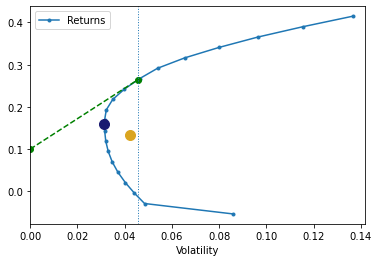

In [19]:
eh.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1,show_eqw=True, show_gmv=True)

FileNotFoundError: [Errno 2] No such file or directory: 'data/ind30_m_ew_rets.csv'